# SAITS Imputation with PyPOTS

> Notebook adapted in parts from [PyPOTS](https://github.com/WenjieDu/PyPOTS/).  <center>  
  <img src="https://raw.githubusercontent.com/WenjieDu/PyPOTS/main/docs/figs/PyPOTS%20logo.svg?sanitize=true" width="150" height="150" />
  </center>

<details>
        <summary> Using your own dataset </summary>
<div>   
```
{
# Install PyPOTS first: pip install pypots  
from pypots.data import mcar, fill_nan_with_mask  
from pypots.imputation import SAITS  
from pypots.utils.metrics import cal_mae  

# ❗️👀 Preprocess your data here to generate X, which should be a NumPy array
# X.shape should be [n_samples, T, D]

# hold out some observed values as ground truth
X_intact, X, missing_mask, indicating_mask = mcar(X, 0.1)
X = fill_nan_with_mask(X, missing_mask)

saits_base = SAITS(n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, dropout=0.1, epochs=100)
saits_base.fit(X) # here use the whole set. You can also split X into train/val/test sets.
imputation = saits_base.impute(X)
mae = cal_mae(imputation, X_intact, indicating_mask)  # calculate mean absolute error on imputation
}```
</div>
</details>


```
# Install PyPOTS first: pip install pypots  
from pypots.data import mcar, fill_nan_with_mask  
from pypots.imputation import SAITS  
from pypots.utils.metrics import cal_mae  

# ❗️👀 Preprocess your data here to generate X, which should be a NumPy array
# X.shape should be [n_samples, T, D]

# hold out some observed values as ground truth
X_intact, X, missing_mask, indicating_mask = mcar(X, 0.1)
X = fill_nan_with_mask(X, missing_mask)

saits_base = SAITS(n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, dropout=0.1, epochs=100)
saits_base.fit(X) # here use the whole set. You can also split X into train/val/test sets.
imputation = saits_base.impute(X)
mae = cal_mae(imputation, X_intact, indicating_mask)  # calculate mean absolute error on imputation
```

In [1]:
import sys
import os
import pathlib
relative_path_to_pypots = 'PyPOTS/'
sys.path.insert(1, os.path.join(sys.path[0], relative_path_to_pypots))


# Install PyPOTS first: pip install pypots
import numpy as np
from sklearn.preprocessing import StandardScaler

from pypots.data import load_specific_dataset, mcar, masked_fill
from pypots.imputation import SAITS
from pypots.utils.metrics import cal_mae

/home2/joshua.wendland/Documents/sepsis/imputation/PyPOTS/PyPOTS_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PhysionNET Dataset
## Data loading and preprocessing

In [28]:
# Data preprocessing. Tedious, but PyPOTS can help. 🤓
data = load_specific_dataset('physionet_2012')  # For datasets in PyPOTS database, PyPOTS will automatically download and extract it.
X = data['X']
num_samples = len(X['RecordID'].unique())

print('num samples: ', num_samples)
print(X)
X = X.drop('RecordID', axis = 1)
X = StandardScaler().fit_transform(X.to_numpy())
X = X.reshape(num_samples, 48, -1)
X_intact, X, missing_mask, indicating_mask = mcar(X, 0.1) # hold out 10% observed values as ground truth
X = masked_fill(X, 1 - missing_mask, np.nan)


Loading the dataset physionet_2012 with TSDB (https://github.com/WenjieDu/Time_Series_Database)...
Starting preprocessing physionet_2012...
Dataset physionet_2012 has already been downloaded. Processing directly...
Dataset physionet_2012 has already been cached. Loading from cache directly...
Loaded successfully!


/home2/joshua.wendland/Documents/sepsis/imputation/PyPOTS/pypots/data/load_specific_datasets.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(missing_part, ignore_index=False, sort=False)  # pad
/home2/joshua.wendland/Documents/sepsis/imputation/PyPOTS/pypots/data/load_specific_datasets.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(missing_part, ignore_index=False, sort=False)  # pad
/home2/joshua.wendland/Documents/sepsis/imputation/PyPOTS/pypots/data/load_specific_datasets.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(missing_part, ignore_index=False, sort=False)  # pad
/home2/joshua.wendland/Documents/sepsis/imputation/PyPOTS/pyp

num samples:  11988
        RecordID  ALP  ALT  AST  Albumin  BUN  Bilirubin  Cholesterol  \
0         132539  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
1         132539  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
2         132539  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
3         132539  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
4         132539  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
...          ...  ...  ...  ...      ...  ...        ...          ...   
575419    163037  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
575420    163037  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
575421    163037  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
575422    163037  NaN  NaN  NaN      NaN  NaN        NaN          NaN   
575423    163037  NaN  NaN  NaN      NaN  NaN        NaN          NaN   

        Creatinine  DiasABP  ...  RespRate  SaO2  SysABP   Temp  TroponinI  \
0              NaN      N

False


<AxesSubplot: xlabel='RecordID'>

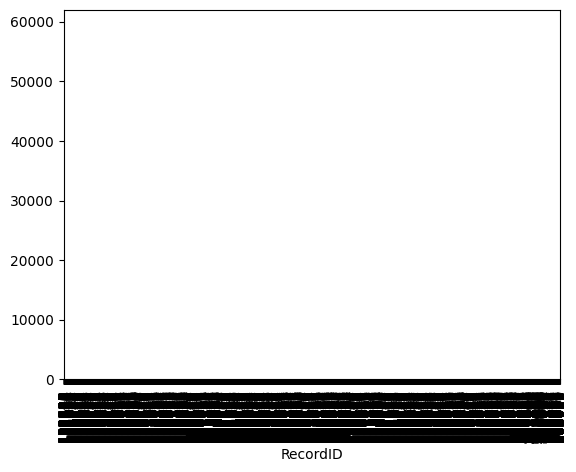

In [30]:
df = data['X']
print('Time' in df.columns)
df[['RecordID', 'Temp']]
df['RecordID'].hist()
df.groupby('RecordID').size().plot.bar()

## Train SAITS model

In [ ]:
# Model training. This is PyPOTS showtime. 💪
saits = SAITS(n_steps=48, n_features=37, n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, dropout=0.1, epochs=10)
saits.fit(X)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
imputation = saits.impute(X)  # impute the originally-missing values and artificially-missing values
mae = cal_mae(imputation, X_intact, indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)

In [3]:
print(mae)

0.23006125629867336


# Toy dataset

The data set here was generated by using a script from the **AFA** repository from *Henrik v. Kleist*.
## Imports

In [2]:
import pandas as pd
import gzip

## Load data and preprocess

In [24]:
path_toydataset = '/home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_1/synthetic_ts_test_data_eav.csv.gz'

df = pd.read_csv(path_toydataset, compression=None)
df = df.sort_values(by=['id', 'time'], ascending=True, ignore_index=True)  # time was not sorted
num_samples = len(df['id'].unique())
print('num samples: ', num_samples)
X = df.drop('id', axis = 1)
X = StandardScaler().fit_transform(X.to_numpy())
X[:,0] = df['time'].to_numpy() # time should not be normalized
X = X.reshape(num_samples, 50, -1)
X_intact, X, missing_mask, indicating_mask = mcar(X, 0.1) # hold out 10% observed values as ground truth
X = masked_fill(X, 1 - missing_mask, np.nan)

num samples:  10


# Model Training

In [28]:
# Model training. This is PyPOTS showtime. 💪
saits = SAITS(n_steps=50, n_features=6, n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, dropout=0.1, epochs=10)
saits.fit(X)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
imputation = saits.impute(X)  # impute the originally-missing values and artificially-missing values
mae = cal_mae(imputation, X_intact, indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)

No given device, using default device: cuda:0
Model initialized successfully. Number of the trainable parameters: 1326476
epoch 0: training loss 10.7180
epoch 1: training loss 10.2635
epoch 2: training loss 9.4288
epoch 3: training loss 8.9207
epoch 4: training loss 7.7365
epoch 5: training loss 7.8497
epoch 6: training loss 7.7298
epoch 7: training loss 7.3733
epoch 8: training loss 6.6401
epoch 9: training loss 6.6071
Finished training.


In [31]:
saits.logger
import tensorboard
